# Music

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21 # must import before fastai. otherwise stream.show() encounters elementtree error
from fastai.text import *

In [3]:
from fastai_data import MusicTokenizer
from encode_data import *
from midi_data import *
import gpt

Failed to load FluidSynth. Must install if you want to convert to wav files.
Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [4]:
# c = music21.corpus.parse(music21.corpus.chorales.Iterator(returnType='filename')[55]) c.show()

In [26]:
music21.environment.get('musicxmlPath')

PosixPath('/Applications/MuseScore 3.app/Contents/MacOS/mscore')

In [5]:
path = Path('data/midi/midi_transcribe_v3_shortdur/')
path.ls()[:5]

[PosixPath('data/midi/midi_transcribe_v3_shortdur/cprato'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/midi_transcribe_v3_shortdur.csv'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/tmp_clc'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/midiworld'),
 PosixPath('data/midi/midi_transcribe_v3_shortdur/wikifonia')]

In [6]:
model_path = 'gpt/pop/ep5_run1'

https://hpml2018.github.io/HPML2018_1.pdf

This paper suggests linear scaling rule does not work with RNNs. 3e-3 seems to be the magical number for 2k-8k

However, they didn't use schedule warmup, so I doubt they optimized the learning rate enough

In [7]:
bs=8
bptt=500

In [10]:
data = TextLMDataBunch.load(path, cache_name='tmp_pop', bs=bs, bptt=bptt)
data.valid_ds.x.processor[0] = TokenizeProcessor(tokenizer=MusicTokenizer())
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos || t0 nC3 t32 nE3 t32 nG3 t32 || t31 nE2 t16',
 array([ 2,  9, 12, 24, ..., 23, 28, 16, 28]))

In [11]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

507

### Load Learner

In [12]:
cuda_enabled = torch.cuda.is_available()

In [13]:
config = gpt.OpenAIGPTConfig(vocab_size)
config.separate_embed = True
model = gpt.OpenAIGPTLMHeadModel(config)
if cuda_enabled: model = model.cuda()
model.reset = lambda: None

In [14]:
config

{
  "afn": "gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "n_ctx": 512,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_special": 0,
  "resid_pdrop": 0.1,
  "separate_embed": true,
  "vocab_size": 507
}

In [15]:
learn = LanguageLearner(data, model, bptt, clip=1)
learn.callbacks = []
# learn = language_model_learner(data, drop_mult=1, clip=.2, bptt=bptt)
learn = learn.load(model_path)

## Done

In [ ]:
learn.show_results(rows=5, max_len=25)

In [17]:
# idx = 3
# idx = 8
seed_len = 80
files = get_files(path/'hooktheory', recurse=True)
# file = files[idx]; file
file = np.random.choice(files); file

PosixPath('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/s/sting/fields-of-gold/verse_key.txt')

In [18]:
best = Path('data/midi/midi_transcribe_v3_shortdur/hooktheory/pianoroll/e/elton-john/tiny-dancer/pre-chorus_key.txt')

In [19]:
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len]); len(notes), seed


(200,
 '|| t12 nC5 t2 || t1 nB4 t2 || t1 nA2 t16 nC3 t16 nE3 t16 nA4 t2 || t1 nG4 t4 || t3 nG4 t4 || t5 nC5 t2 || t1 nB4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t2 || t1 nG4 t4 || t3 nA4 t4 || t7 nC4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t4 || t3 nG4 t2 || t1 nG4 t6 || t5 nC4 t2 || t1')

In [19]:
ns = str2stream(seed)
ns.show('midi')

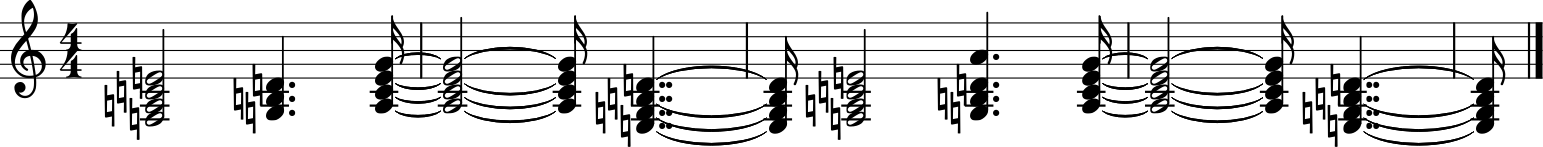

In [20]:
ns = str2stream(seed).show()

In [27]:
seed

'|| t12 nC5 t2 || t1 nB4 t2 || t1 nA2 t16 nC3 t16 nE3 t16 nA4 t2 || t1 nG4 t4 || t3 nG4 t4 || t5 nC5 t2 || t1 nB4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t2 || t1 nG4 t4 || t3 nA4 t4 || t7 nC4 t2 || t1 nF2 t16 nA2 t16 nC3 t16 nA4 t4 || t3 nG4 t2 || t1 nG4 t6 || t5 nC4 t2 || t1'

In [21]:
# full song
str2stream(' '.join(notes)).show('midi')

### Beam search

In [20]:
from beam_search import *

In [ ]:
pred_beam, idxs = beam_search(seed, seq_length=200, beam_size=4, learn=learn, temperature=2)
pred_beam_only = pred_beam.replace(seed, '').strip(); pred_beam_only

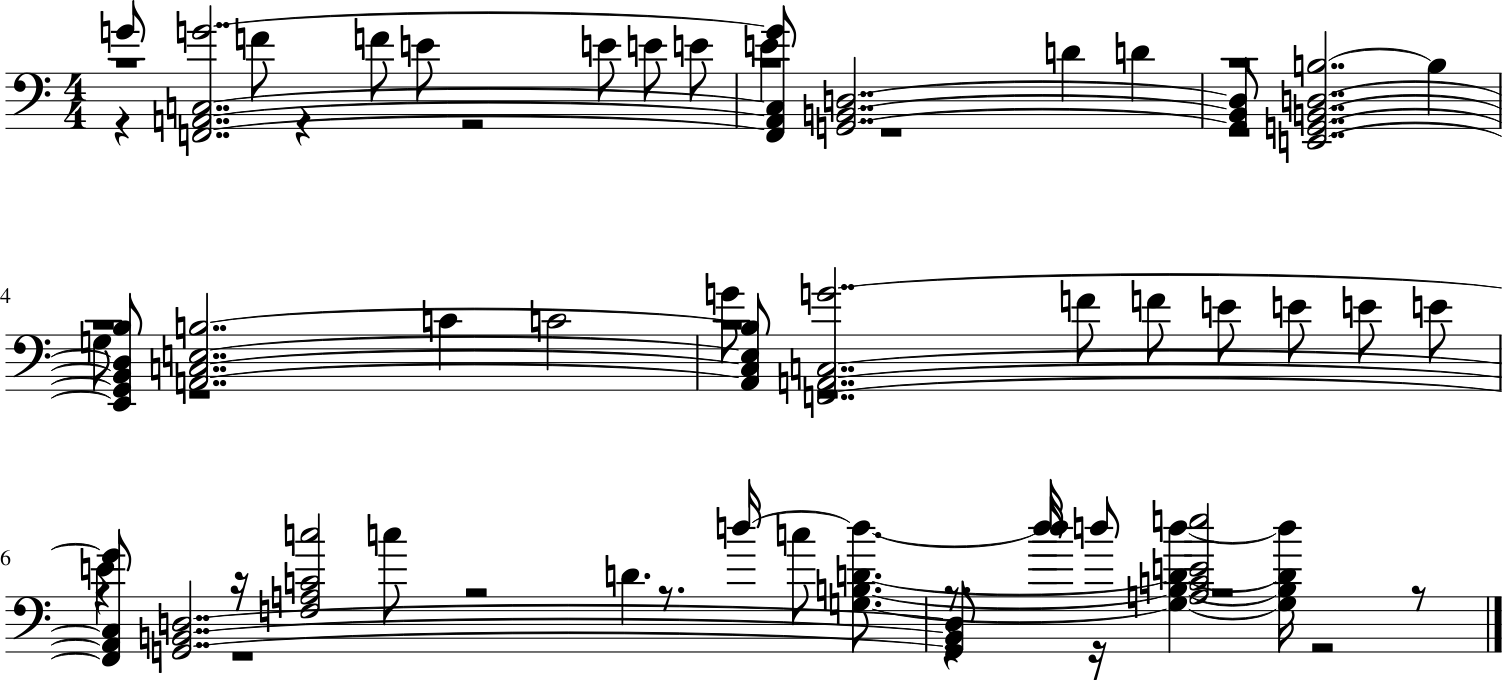

In [171]:
ns_only = str2stream(pred_beam_only).show()

In [172]:
ns_only = str2stream(pred_beam_only)
ns_only.show('midi')

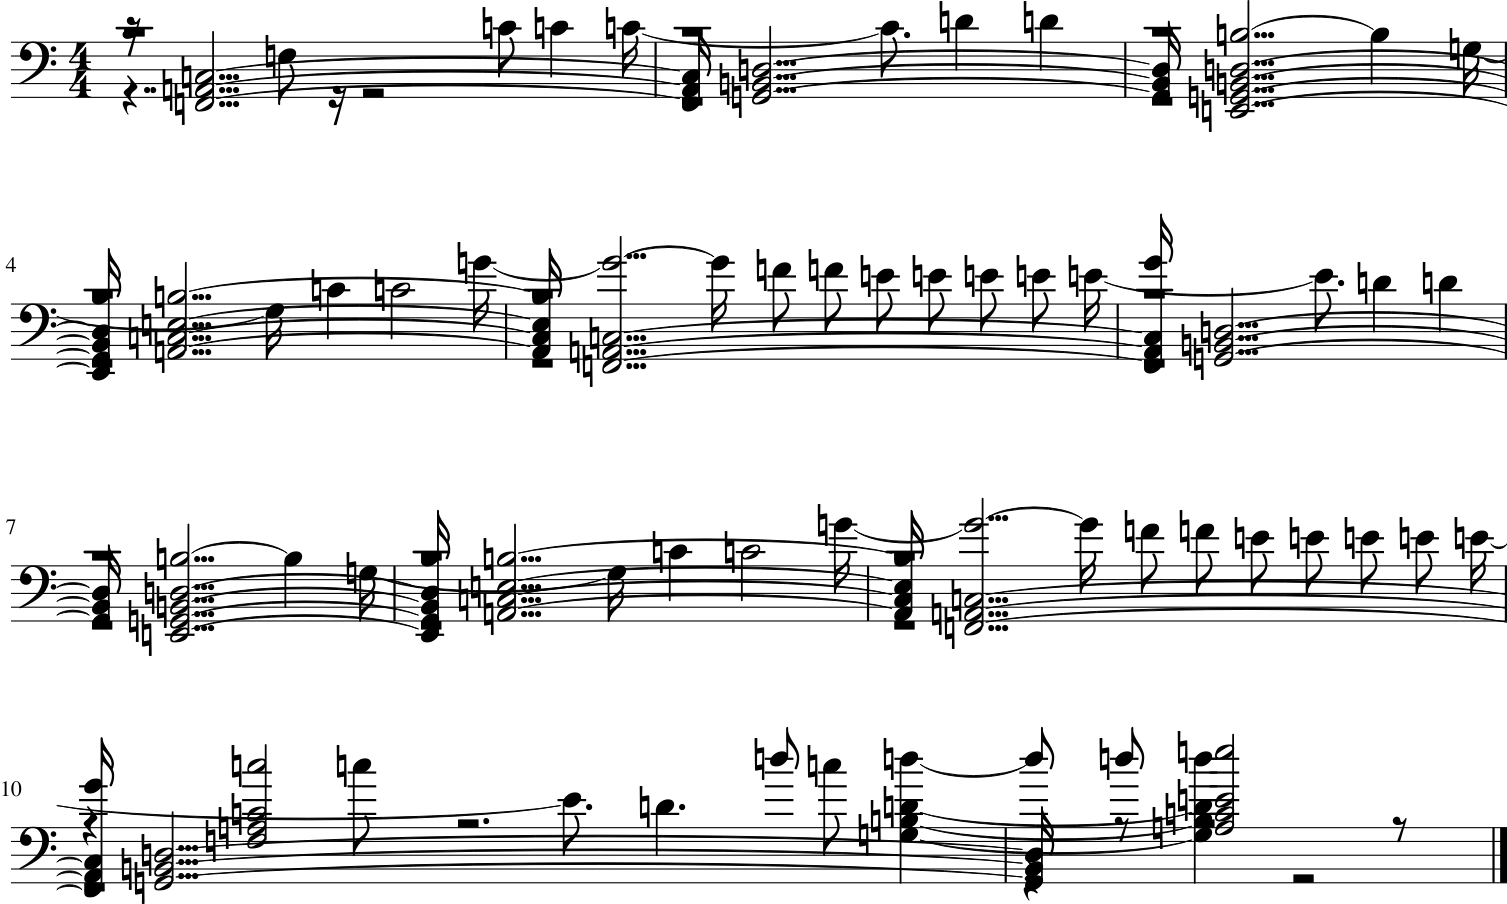

In [173]:
ns = str2stream(pred_beam).show()

In [174]:
ns = str2stream(pred_beam)
ns.show('midi')

### Predictions without beam search

In [ ]:
pred_out = learn.predict(seed, n_words=200); pred_out

In [25]:
seed

'|| t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nG#3 t4 nD4 t4 nE4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nG#3 t3 nD4 t3 nE4 t3 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 nG#3 t1 nD4 t1 nE4 t1 || t0 nE1 t1 nE2 t1 nA3 t8 nD4 t8 nF#4 t8 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nB3 t4 nD4 t4 nG#4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nB3 t3 nD4 t3 nG#4 t3 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 nB3 t1 nD4 t1 nG#4 t1 || t0 nE1 t1 nE2 t1 nC#4 t8 nE4 t8 nA4 t8 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 nE2 t1 nD4 t4 nG#4 t4 nB4 t4 || t0 nE1 t1 nE2 t1 || t0 nE1 t1 || t0 nE1 t1 nE2 t

In [ ]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

In [ ]:
ns = str2stream(pred_only)
ns.show('midi')

In [26]:
str2seq(pred_only)

't'


[[E2t1],
 [E1t1],
 [E1t1, E2t1, D4t5, E4t5],
 [E1t1, E2t1],
 [E1t1],
 [E1t1, E2t1],
 [E2t1, A3t4, C#4t4, F#4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [],
 [E1t1, E2t1],
 [],
 [E2t1, C#4t4, F4t4, G#4t4, B4t4],
 [],
 [],
 [E2t1],
 [E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1, C4t4, E4t4, A4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1, A3t4, C#4t4, F#4t4],
 [E1t1, E2t1],
 [E1t1],
 [E1t1, E2t1, B3t4, D4t4, G#4t4],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1],
 [E1t1, E2t1]]

In [27]:
note_stream = str2stream(pred_out)

't'
